Saving production.csv to production.csv
Missing values:
 password    0
strength    0
dtype: int64

Class distribution:
 strength
1    100000
2    100000
0    100000
Name: count, dtype: int64


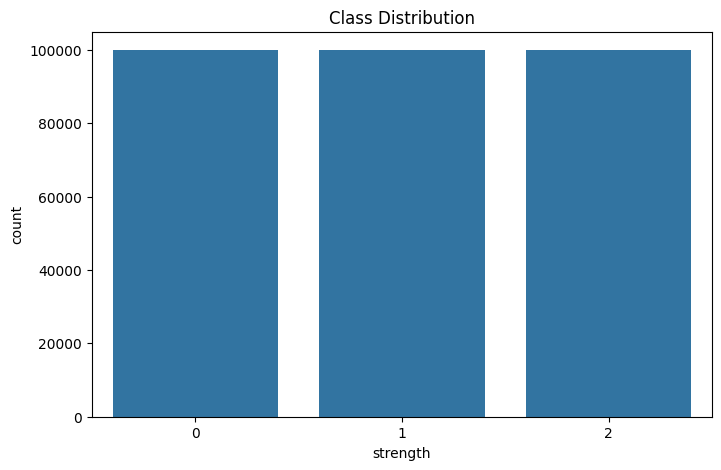


Training Random Forest...
Random Forest Accuracy: 0.9244
              precision    recall  f1-score   support

           0       0.94      0.85      0.90     20000
           1       0.85      0.95      0.89     20000
           2       1.00      0.97      0.98     20000

    accuracy                           0.92     60000
   macro avg       0.93      0.92      0.92     60000
weighted avg       0.93      0.92      0.92     60000


Training SVM...


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==========================
from google.colab import files
uploaded = files.upload()

# Assume the file is named 'production.csv'
df = pd.read_csv('production.csv')

# Data preprocessing
# Handle special tokens like ###COMMA### (replace with actual comma)
df['password'] = df['password'].str.replace('###COMMA###', ',')
df['password'] = df['password'].str.replace('""', '"')  # Clean up quotes

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check class distribution
print("\nClass distribution:\n", df['strength'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='strength', data=df)
plt.title('Class Distribution')
plt.show()

# Split data into train and test sets
X = df['password']
y = df['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Character-level n-gram feature extraction
# Using TF-IDF for character n-grams (bi-grams and tri-grams)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2, 3), min_df=0.001)
X_train_tfidf = tfidf_char.fit_transform(X_train)
X_test_tfidf = tfidf_char.transform(X_test)

# Traditional Machine Learning Models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Compare model performance
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison (Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

# Deep Learning Approach (Character-level LSTM/CNN)

# Prepare data for deep learning
# Encode characters
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Number of unique characters
vocab_size = len(tokenizer.word_index) + 1

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# LSTM Model
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len),
        LSTM(64, return_sequences=True),
        LSTM(32),




        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

# Train LSTM
history_lstm = lstm_model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=10,
    batch_size=64,
    verbose=1
)

# CNN Model
def build_cnn_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn_model()
cnn_model.summary()

# Train CNN
history_cnn = cnn_model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=10,
    batch_size=64,
    verbose=1
)

# Plot training history
def plot_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history_lstm, 'LSTM')
plot_history(history_cnn, 'CNN')

# Evaluate deep learning models
lstm_score = lstm_model.evaluate(X_test_pad, y_test_cat, verbose=0)
cnn_score = cnn_model.evaluate(X_test_pad, y_test_cat, verbose=0)

results['LSTM'] = lstm_score[1]
results['CNN'] = cnn_score[1]

# Final comparison
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values())
plt.title('Final Model Comparison (Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

# Print all results
print("\nFinal Model Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

Saving production.csv to production (4).csv
Missing values:
 password    0
strength    0
dtype: int64

Class distribution:
 strength
1    100000
2    100000
0    100000
Name: count, dtype: int64


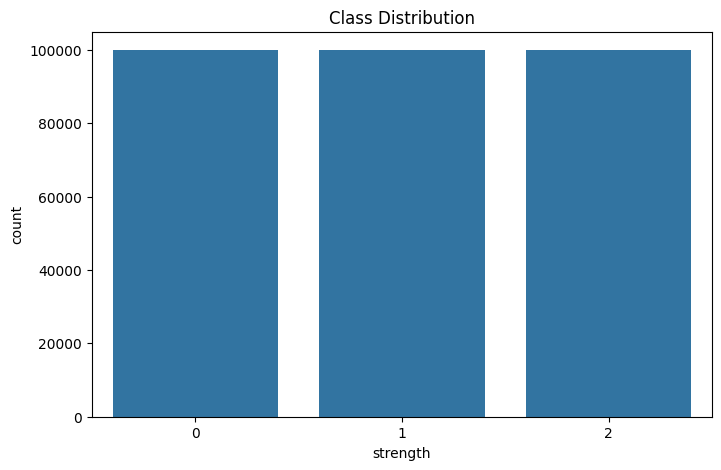


Training Random Forest...
Random Forest Accuracy: 0.7097
              precision    recall  f1-score   support

           0       0.57      0.94      0.71     20000
           1       0.82      0.31      0.45     20000
           2       0.91      0.88      0.89     20000

    accuracy                           0.71     60000
   macro avg       0.77      0.71      0.68     60000
weighted avg       0.77      0.71      0.68     60000


Training XGBoost...
XGBoost Accuracy: 0.8697
              precision    recall  f1-score   support

           0       0.95      0.68      0.80     20000
           1       0.73      0.98      0.84     20000
           2       1.00      0.94      0.97     20000

    accuracy                           0.87     60000
   macro avg       0.90      0.87      0.87     60000
weighted avg       0.90      0.87      0.87     60000

Epoch 1/6
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 156s 41ms/step - accuracy: 0.6485 - loss: 0.6592 - val_accuracy: 0.8486 - val_loss: 0.3825
Ep

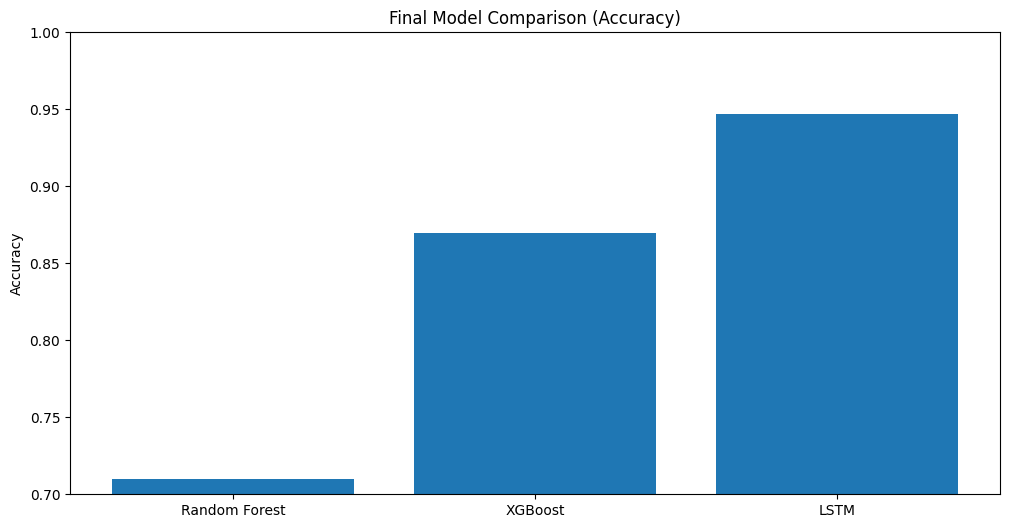


Final Model Accuracies:
Random Forest: 0.7097
XGBoost: 0.8697
LSTM: 0.9471


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ==========================
# Upload the dataset
from google.colab import files
uploaded = files.upload()

# Read the dataset (assuming it's a CSV file)
df = pd.read_csv('production.csv')  # Changed from read_excel to read_csv

# Data preprocessing
df['password'] = df['password'].str.replace('###COMMA###', ',')
df['password'] = df['password'].str.replace('""', '"')

# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Check class distribution
print("\nClass distribution:\n", df['strength'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='strength', data=df)
plt.title('Class Distribution')
plt.show()

# Split data into train and test sets
X = df['password']
y = df['strength']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Character-level n-gram feature extraction (reduce ngram_range to (2,2) for faster results)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(2, 2), min_df=0.001, max_features=5000)  # Reduce max_features
X_train_tfidf = tfidf_char.fit_transform(X_train)
X_test_tfidf = tfidf_char.transform(X_test)

# Traditional Machine Learning Models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42),  # Reduced n_estimators
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', max_depth=5)  # Reduced max_depth
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))

# Deep Learning Approach (Character-level LSTM)

# Prepare data for deep learning
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_len = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Number of unique characters
vocab_size = len(tokenizer.word_index) + 1

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# LSTM Model with EarlyStopping
def build_lstm_model():
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=32, input_length=max_len),
        LSTM(32),  # Reduce the number of units
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train LSTM
lstm_model = build_lstm_model()
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history_lstm = lstm_model.fit(
    X_train_pad, y_train_cat,
    validation_data=(X_test_pad, y_test_cat),
    epochs=6,  # Reduced number of epochs
    batch_size=64,  # Increased batch size for faster training
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the deep learning model
lstm_score = lstm_model.evaluate(X_test_pad, y_test_cat, verbose=0)
results['LSTM'] = lstm_score[1]

# Final comparison
plt.figure(figsize=(12, 6))
plt.bar(results.keys(), results.values())
plt.title('Final Model Comparison (Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)
plt.show()

# Print all results
print("\nFinal Model Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")
